In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 

In [2]:
df = pd.read_csv('R:/manufacturing prediction/large_indian_spoilage_dataset.csv')


In [3]:
label_encoder = LabelEncoder()
df['Type_encoded'] = label_encoder.fit_transform(df['Type'])

In [4]:
X = df[['Type_encoded', 'Fridge_Temperature_C', 'Humidity_Percentage']]
y = df['Spoilage_Days']


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "Support Vector Regressor": SVR(kernel='rbf')
}


In [7]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R²': r2}
    print(f"{name} - Mean Squared Error: {mse}, R² Score: {r2}")


Random Forest - Mean Squared Error: 0.12455780000000004, R² Score: 0.9994352682471462
Gradient Boosting - Mean Squared Error: 10.529183061185696, R² Score: 0.9522618093265798
Linear Regression - Mean Squared Error: 208.3726510493462, R² Score: 0.05526067035635929
Support Vector Regressor - Mean Squared Error: 227.53761556324673, R² Score: -0.031631230458488035


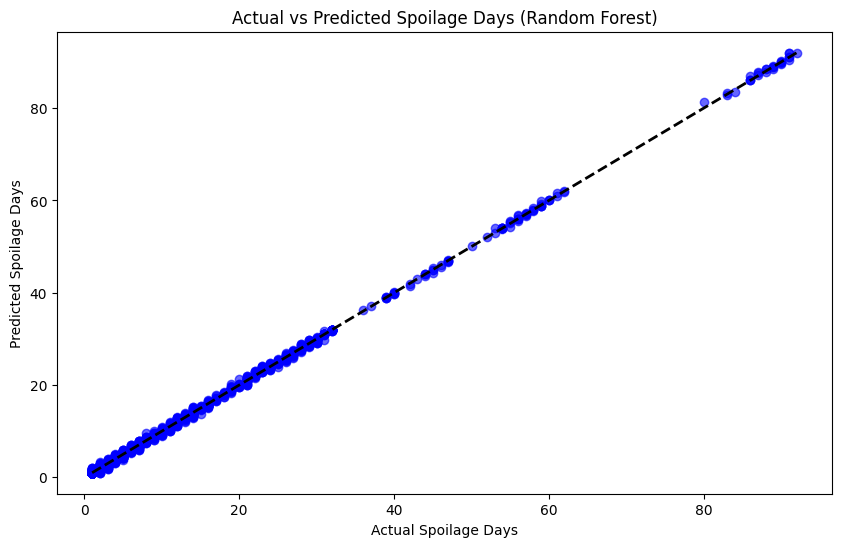

In [8]:
best_model_name = min(results, key=lambda x: results[x]['MSE'])
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_best, alpha=0.6, color='b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Spoilage Days')
plt.ylabel('Predicted Spoilage Days')
plt.title(f'Actual vs Predicted Spoilage Days ({best_model_name})')
plt.show()


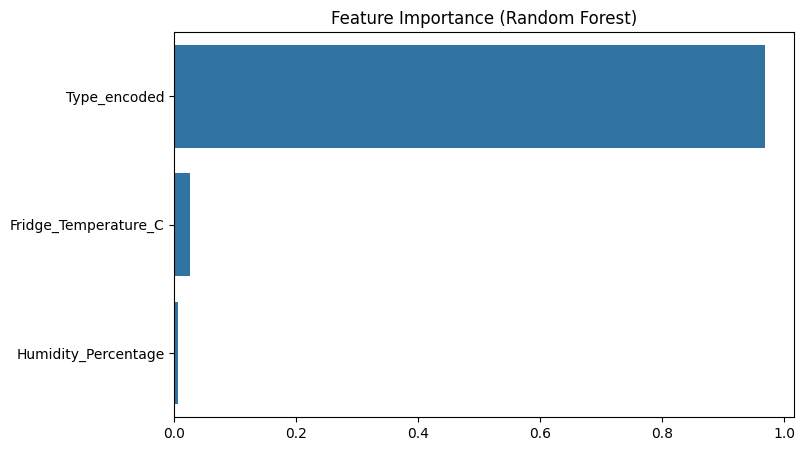

In [9]:
if best_model_name == "Random Forest":
    feature_importance = best_model.feature_importances_
    features = ['Type_encoded', 'Fridge_Temperature_C', 'Humidity_Percentage']
    plt.figure(figsize=(8,5))
    sns.barplot(x=feature_importance, y=features)
    plt.title('Feature Importance (Random Forest)')
    plt.show()

In [10]:
input_data = pd.DataFrame({
    'Type_encoded': label_encoder.transform([
        'Green Chili', 'French Beans', 'Spinach', 
        'Radish', 'Pomegranate', 'Pointed Gourd', 'Turnip', 'Garlic'
    ]),
    'Fridge_Temperature_C': [
        5.41279389, 5.263695413, 2.539913553, 
        2.44814993, 4.864201808, 6.913333372, 5.908143435, 6.338460299
    ],
    'Humidity_Percentage': [
        77.14733701, 84.93901332, 59.78863411, 
        66.85151878, 59.17449329, 68.39420845, 59.7504884, 59.46013022
    ]
})


In [11]:
predictions = best_model.predict(input_data)
input_data['Predicted_Spoilage_Days'] = predictions
input_data['Type'] = label_encoder.inverse_transform(input_data['Type_encoded'])

In [12]:
print(input_data[['Type', 'Fridge_Temperature_C', 'Humidity_Percentage', 'Predicted_Spoilage_Days']])


            Type  Fridge_Temperature_C  Humidity_Percentage  \
0    Green Chili              5.412794            77.147337   
1   French Beans              5.263695            84.939013   
2        Spinach              2.539914            59.788634   
3         Radish              2.448150            66.851519   
4    Pomegranate              4.864202            59.174493   
5  Pointed Gourd              6.913333            68.394208   
6         Turnip              5.908143            59.750488   
7         Garlic              6.338460            59.460130   

   Predicted_Spoilage_Days  
0                     5.85  
1                     1.84  
2                     5.99  
3                    12.00  
4                    28.01  
5                     8.99  
6                    18.03  
7                    85.99  


In [13]:
actual_spoilage = df[df['Type'].isin(input_data['Type'].values)][['Type', 'Spoilage_Days']].reset_index(drop=True)
input_data = input_data.merge(actual_spoilage, on='Type', how='left')
input_data.rename(columns={'Spoilage_Days': 'Actual_Spoilage_Days'}, inplace=True)


In [14]:
print(input_data[['Type', 'Fridge_Temperature_C', 'Humidity_Percentage', 'Actual_Spoilage_Days', 'Predicted_Spoilage_Days']])

             Type  Fridge_Temperature_C  Humidity_Percentage  \
0     Green Chili              5.412794            77.147337   
1     Green Chili              5.412794            77.147337   
2     Green Chili              5.412794            77.147337   
3     Green Chili              5.412794            77.147337   
4     Green Chili              5.412794            77.147337   
...           ...                   ...                  ...   
1551       Garlic              6.338460            59.460130   
1552       Garlic              6.338460            59.460130   
1553       Garlic              6.338460            59.460130   
1554       Garlic              6.338460            59.460130   
1555       Garlic              6.338460            59.460130   

      Actual_Spoilage_Days  Predicted_Spoilage_Days  
0                        6                     5.85  
1                        6                     5.85  
2                        8                     5.85  
3              

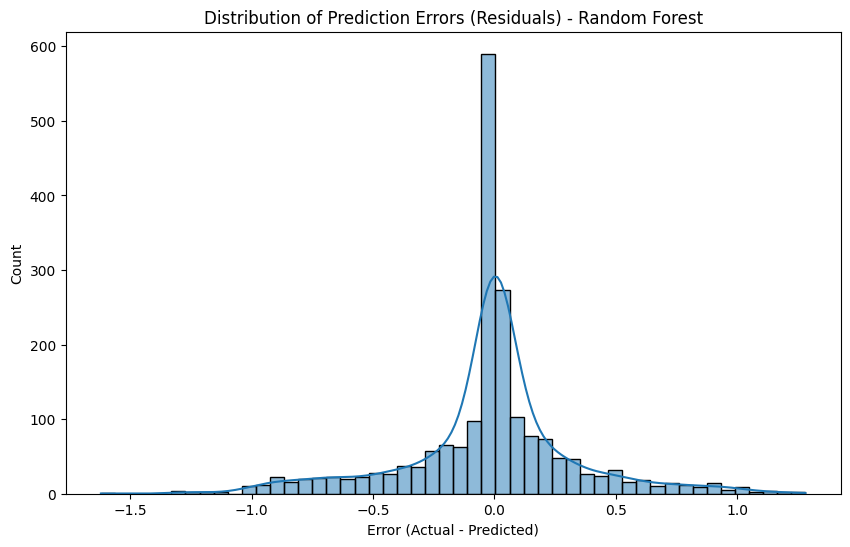

In [15]:
errors = y_test - y_pred_best
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=50, kde=True)
plt.title(f'Distribution of Prediction Errors (Residuals) - {best_model_name}')
plt.xlabel('Error (Actual - Predicted)')
plt.show()

In [16]:
joblib.dump(best_model, f"{best_model_name.replace(' ', '_')}_model.pkl")
print(f"{best_model_name} model exported as {best_model_name.replace(' ', '_')}_model.pkl")


Random Forest model exported as Random_Forest_model.pkl
